# Coastal Erosion Case Study

### Background
Over 40% of the world’s population lives within 100 km of the coastline. However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats. Up-to-date data on coastal change and erosion is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion.

### The Problem
Monitoring coastlines and rivers using field surveys can be challenging and hazardous, particularly at regional or national scale. Aerial photography and LiDAR can be used to monitor coastal change, but this is often expensive and requires many repeated flights over the same areas of coastline to build up an accurate history of how the coastline has changed across time.

### Digital Earth Africa use case
Imagery from satellites such as the NASA/USGS Landsat program is available for free for the entire planet, making satellite imagery a powerful and cost-effective tool for monitoring coastlines and rivers at regional or national scale. By identifying and extracting the precise boundary between water and land based on satellite data, it is possible to extract accurate shorelines that can be compared across time to reveal hotspots of erosion and coastal change.

The usefulness of satellite imagery in the coastal zone can be affected by the presence of clouds, sun-glint over water, poor water quality (e.g. sediment) and the influence of tides. The effect of these factors can be reduced by combining individual noisy images into cleaner "summary" or composite layers, and filtering the data to focus only on images taken at certain tidal conditions (e.g. high tide). 

In this example, we combine data from the Landsat 5, 7 and 8 satellites with image compositing and tide filtering techniques to accurately map shorelines across time, and identify areas that have changed significantly between 1987 and 2018. The worked example takes users through the code required to:

1.  Load in a cloud-free Landsat time series
2.  Compute a water index (MNDWI)
3.  Filter images by tide height
4.  Create "summary" or composite images for given time periods
5.  Extract and visualise shorelines across time

### Technical details

* Products used: `ls5_usgs_sr_scene`, `ls7_usgs_sr_scene`, `ls8_usgs_sr_scene`
* Bands used: `red`, `green`, `blue` and `swir1`. You can read more about the bands available for Landsat [here](https://landsat.gsfc.nasa.gov/landsat-8/landsat-8-bands/)
* Analyses used: MNDWI water index, tide filtering, image compositing, waterline extraction

**To run this analysis, run all the cells in the notebook, starting with the "Load modules" cell. When you finished the analysis, you can return to the "Set up analysis" cell, modify some values (e.g. choose a different location, time, tide height range or time period to analyse) and re-run the analysis. There are additional instructions on modifying the notebook at the end.**

## Load modules

In [1]:
# Magic + imports
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('/home/jovyan/odc-hub/')

In [2]:
import datacube
import sys
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import utils_sac.waterline_functions_deaafrica as waterline_funcs
from utils_sac.clean_mask import landsat_qa_clean_mask

## Set up analysis

The following lines allow us to set up our analysis by selecting the location (`lat_range` and `lon_range`) and time (`time_range`) we want to investigate. We can also set two other important parameters: `tide_range` allows us to extract shorelines based on satellite images taken only at certain part of the tide range (e.g. at low or high tide). This can be useful for seperating the effect of erosion from the influence of tides. Finally, the `time_step` parameter allows us to choose the length of the time periods we want to compare: e.g. shorelines for each year, or shorelines for each six months etc:

* **lat_range:** The latitude range to analyse (e.g. `(-12.20, -12.27)`). For fast load times, keep this to a range of ~0.1 degrees or less.

* **lon_range:** The longitude range to analyse (e.g. `(131.80, 131.91)`). For fast load times, keep this to a range of ~0.1 degrees or less.

* **time_range:** The date range to analyse (e.g. `('2013-01-01', '2018-12-31') `)

* **time_step:** The time period to compare coastline change. `1Y` will generate one coastline for every year in the dataset; `6M` will produce a coastline for every six months, etc.

* **tide_range:** The lowest and highest tide heights to analyse (e.g. `(0.00, 4.00)` in metre units). This will remove all images with tides outside this range from the dataset, allowing you to produce shorelines for specific tidal conditions (e.g. low tide, average tide, high tide etc)

* **tide_file:** A text file containing a list of times and tide heights for a location near to the study area. These tides are used to filter the satellite dataset to focus on images taken at certain tide conditions. Tide height files are stored in the `tide_heights` folder and are named using the following convention: `locationname_latitude_longitude_tides.csv`.

* **output_projection:** The map projection system that the shorelines will be extracted in. Ideally, this is the same as the data is stored on file to avoid resampling issues (typically in UTM zones).

### Edit these lines to change any of the analysis parameters

If you're running this notebook for the first time, we recommend you keep the default settings below. This will allow you to understand how the analysis works.

The example we've selected looks at erosion at Fuveme village in Ghana (for more information about the West African erosion crisis, see: https://foreignpolicy.com/2016/10/21/west-africa-is-being-swallowed-by-the-sea-climate-change-ghana-benin/). To explore some other locations, uncomment the 'Varela, Guinea Bissau' and 'Nouakchott, Mauritania' code below!

Run the following cell to set values for the various parameters discussed above.

In [54]:
# Fuveme, Ghana
#lat_range = (5.75, 5.80)
#lon_range = (0.65, 0.73) 
#time_range = ('1987', '2018') 
#time_step = '2Y'
#tide_range = (0.00, 10.00)
#tide_file = 'data/tide_heights/fuveme_5.77_0.69_tides.csv'
#output_projection = 'EPSG:32631'

lon_range = (177.481, 177.855)
lat_range = (-18.00, -18.3732)
#smaller area
#lon_range = (177.36740112307, 177.46044158938)
#lat_range = (-18.107528686523, -18.159027099609)
time_range = ("2017", "2018")
tide_range = (0.00, 10.00)
time_step = '1Y'
output_projection = "EPSG:32760"

path = "/home/shared/geo_demos/tides/"
tide_file_2017 = "/home/shared/geo_demos/tides/IDO70004_2017.csv"
tide_file_2018 = "/home/shared/geo_demos/tides/IDO70004_2018.csv"
#tide_file = [path + 'IDO70004_2017.csv', path + '/IDO70004_2018.csv', path + '/IDO70004_2019.csv']

#time = ("2017-01-02", "2017-02-01")


# # Varela, Guinea Bissau
# lat_range = (12.26, 12.30)   
# lon_range = (-16.61, -16.55) 
# time_range = ('1987', '2018') 
# time_step = '2Y'
# tide_range = (0.00, 10.00)
# tide_file = 'data/tide_heights/varela_12.27_-16.59_tides.csv'
# output_projection = 'EPSG:32628'

# # Nouakchott, Mauritania
# lat_range = (17.92, 18.035)   
# lon_range = (-16.05, -16.017) 
# time_range = ('1987', '2018') 
# time_step = '2Y'
# tide_range = (0.00, 10.00)
# tide_file = 'data/tide_heights/nouakchott_17.99_-16.05_tides.csv'
# output_projection = 'EPSG:32628'


### View the selected location

The next cell will display the selected area on an interactive map. Feel free to zoom in and out to get a better understanding of the area you'll be analysing. Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [44]:
waterline_funcs.display_map(latitude=lat_range, longitude=lon_range)

## Load cloud-masked Landsat data
The first step in this analysis is to load in Landsat data for the `lat_range`, `lon_range` and `time_range` we provided above. The code below first connects to the datacube database, and then uses the `load_cloudmaskedlandsat` function to load in data from the Landsat 5, 7 and 8 satellites for the area and time included in `lat_range`, `lon_range` and `time_range`. The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [45]:
# Connect to the datacube
dc = datacube.Datacube(app='Coastal erosion')

# Create the 'query' dictionary object, which contains the longitudes, latitudes and time provided above
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time_range,
    'output_crs': output_projection,  
    'resolution': (-90, 90)
}


landsat_ds = dc.load(product="ls8_usgs_sr_scene",
               group_by='solar_day',
               measurements = ["green","red", "blue", "nir","swir1","swir2","coastal_aerosol","pixel_qa"],
               **query)
# Load satellite data for all Landsat satellites (5, 7 and 8) from 1987 onward
#landsat_ds = landsat_qa_clean_mask(dc, query, 
#    bands=['red', 'green', 'blue', 'swir1', 'pixel_qa'])

print(landsat_ds)

<xarray.Dataset>
Dimensions:          (time: 80, x: 442, y: 462)
Coordinates:
  * time             (time) datetime64[ns] 2017-01-07T22:06:49.107044 ... 2018-12-28T22:06:30.216454
  * y                (y) float64 8.01e+06 8.01e+06 ... 7.968e+06 7.968e+06
  * x                (x) float64 5.508e+05 5.509e+05 ... 5.904e+05 5.905e+05
Data variables:
    green            (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    red              (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    blue             (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    nir              (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    swir1            (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    swir2            (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    coastal_aerosol  (time, y, x) int16 -9999 -9999 -9999 ... -9999 -9999 -9999
    pixel_qa         (time, y, x) uint16 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1
Attributes:


### Plot example timestep in true colour
To verify that we extracted data for the area we're interested in analysing, we can plot up the first image in the dataset in true colour. This makes use of the `red`, `green` and `blue` Landsat bands that we loaded in the previous cell.

Change `index=0` to another value (e.g. `index=1`) to plot up different timesteps. You should be able to clearly see where clouds have been masked out.

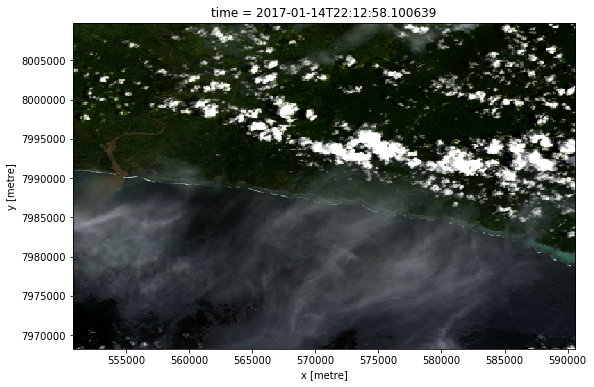

In [50]:
waterline_funcs.rgb(landsat_ds, index=1)

In [51]:
scenes = landsat_ds
clearsky_masks = landsat_qa_clean_mask(scenes, 'LANDSAT_8')
clearsky_scenes = scenes.where(clearsky_masks)

## Compute Modified Normalised Difference Water Index
To extract shoreline locations, we need to be able to seperate water from land in our study area. To do this, we can use our Landsat data to calculate a water index called the `Modified Normalised Difference Water Index`, or MNDWI. This index uses the ratio of green and mid-infrared radiation to identify the presence of water. You can find more information on it in the [original research article](http://www.aari.ru/docs/pub/060804/xuh06.pdf). The formula is:

$$
\begin{aligned}
\text{MNDWI} &= \frac{(Green - MIR)}{(Green + MIR)}
\end{aligned}
$$

where `Green` is the green band and `MIR` is the mid-infrared band. For Landsat, we can use the Short-wave Infrared (SWIR) 1 band as our measure for `MIR`.

When it comes to interpreting the index, **High values (greater than 0, blue colours) typically represent water pixels**, while **low values (less than 0, red colours) represent land**. You can use the cell below to calculate and plot one of the images after calculating the index.

NameError: name 'wofs_classify' is not defined

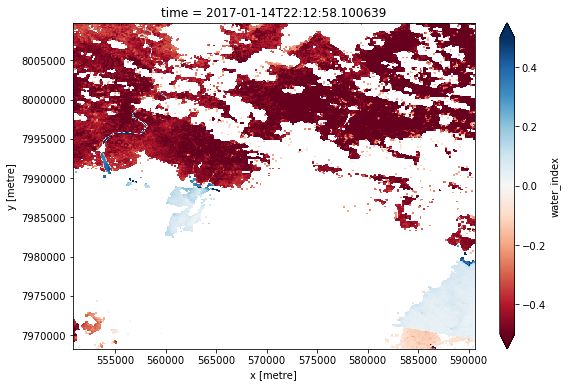

In [65]:
#clearsky_scenes['water_index'] = ((clearsky_scenes.green - clearsky_scenes.swir1) / (clearsky_scenes.green + clearsky_scenes.swir1))
#clearsky_scenes.water_index.isel(time=1).plot(cmap='RdBu', size=6, vmin=-0.5, vmax=0.5)
#water_classes = wofs_classify(scenes, clean_mask=clearsky_masks.values , no_data = np.nan , x_coord='x', y_coord = "y")
landsat_ds['water_index'] = ((landsat_ds.green - landsat_ds.swir1) / (landsat_ds.green + landsat_ds.swir1))
landsat_ds.water_index.isel(time=1).plot(cmap='RdBu', size=6, vmin=-0.5, vmax=0.5)
plt.show()

How does the plot of the index compare to the optical image from earlier? Was there water or land anywhere you weren't expecting?

## Import tide height data
The location of the shoreline can vary greatly from low to high tide. In the code below, we aim to reduce the effect of tides by loading in tide height data, and keeping only the satellite images that were taken at specific tidal conditions. For example, if `tide_range = (0.00, 2.00)`, we are telling the analysis to focus only on satellite images taken when the tide was between `0.00 m` and `2.00 m` relative to Mean Sea Level.

For this example notebook, we will use tide data for a single location off the coast of Fuveme, Ghana. You can load the existing tide height data in the following cell using the `pandas` module, which we imported earlier. The code will read the `tide_file` variable provided during the set up.

In [55]:
tide_data_2017 = pd.read_csv(tide_file_2017, parse_dates=['time'], index_col='time')
tide_data_2018 = pd.read_csv(tide_file_2018, parse_dates=['time'], index_col='time')
tide_data = pd.concat([tide_data_2017, tide_data_2018])
#df_row = pd.concat([df1, df2])
tide_data.head()
tide_data['tide_height'] = tide_data['tide']
tide_data.head()

,tide,Water Temperature,Air Temperature,Barometric Pressure,Residuals,Adjusted Residuals,Wind Direction,Wind Gust,Wind Speed,Lautoka,Fiji,tide_height
time,,,,,,,,,,,,
2017-01-01 00:00:00,1.082,29.5,29.9,1006.2,-0.069,-0.133,330,3.3,1.0,NaN,NaN,1.082
2017-01-01 01:00:00,0.888,29.6,30.2,1005.7,-0.037,-0.107,347,3.5,1.2,NaN,NaN,0.888
2017-01-01 02:00:00,0.791,29.9,30.4,1005.5,-0.035,-0.111,338,4.5,1.3,NaN,NaN,0.791
2017-01-01 03:00:00,0.885,30.2,30.0,1005.1,-0.008,-0.085,341,4.1,1.7,NaN,NaN,0.885
2017-01-01 04:00:00,1.093,30.3,30.0,1004.8,-0.005,-0.086,303,4.4,1.4,NaN,NaN,1.093


Now that we have the tide height data, we need to estimate the tide height for each of our Landsat 8 images. We can do this by interpolating between the data points we do have to get the tide height when each image was taken.

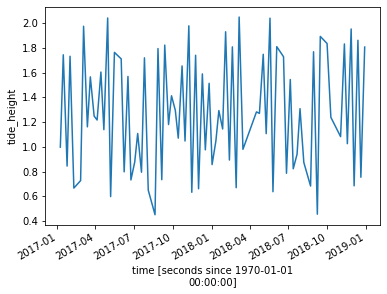

In [56]:
# First, we convert the data to an xarray dataset so we can analyse it in the same way as our Landsat data
tide_data_xr = tide_data.to_xarray()

# We want to convert our hourly tide heights to estimates of exactly how high the tide was at the time that
# each satellite image was taken. To do this, we can use `.interp` to 'interpolate' a tide height for each
# Landsat timestamp:
landsat_tideheights = tide_data_xr.interp(time=landsat_ds.time)
#landsat_tideheights = tide_data_xr.interp(time=clearsky_scenes.time)

# We then want to put these values back into the Landsat dataset so that each image has an estimated tide height:
landsat_ds['tide_height'] = landsat_tideheights.tide_height
#clearsky_scenes['tide_height'] = landsat_tideheights.tide_height


# Plot the resulting tide heights for each Landsat image:
landsat_ds.tide_height.plot()
#clearsky_scenes.tide_height.plot()
plt.show()

The plot above should make it clear that limiting the range of the tides for the analysis should give you more consistent results. Consistency is critical as you want to compare the change in the shoreline from year to year, and large variance in the tide height could obscure your results.

### Filter Landsat images by tide height
Here we take the Landsat dataset and only keep the images with tide heights we want to analyse (i.e. tides within the heights given by `tide_range`). This will result in a smaller number of images (e.g. only high tide images):

In [57]:
landsat_hightide = landsat_ds.where((landsat_ds.tide_height > tide_range[0]) & 
                                    (landsat_ds.tide_height < tide_range[1]), drop=True)
#landsat_hightide = clearsky_scenes.where((clearsky_scenes.tide_height > tide_range[0]) & 
 #                                  (clearsky_scenes.tide_height < tide_range[1]), drop=True)
print(landsat_hightide)

<xarray.Dataset>
Dimensions:          (time: 80, x: 442, y: 462)
Coordinates:
  * time             (time) datetime64[ns] 2017-01-07T22:06:49.107044 ... 2018-12-28T22:06:30.216454
  * y                (y) float64 8.01e+06 8.01e+06 ... 7.968e+06 7.968e+06
  * x                (x) float64 5.508e+05 5.509e+05 ... 5.904e+05 5.905e+05
Data variables:
    green            (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    red              (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    blue             (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    nir              (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    swir1            (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    swir2            (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    coastal_aerosol  (time, y, x) float64 -9.999e+03 -9.999e+03 ... -9.999e+03
    pixel_qa         (time, y, x) float64 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    water_index      (

## Create water index summary images
Individual remote sensing images can be affected by noisy data, including clouds, sunglint and poor water quality conditions (e.g. sediment). To produce cleaner images that can be compared more easily across time, we can create 'summary' images or composites that combine multiple images into one image to reveal the 'typical' or median appearance of the landscape for a certain time period. In this case, we use the median as the summary statistic because it prevents strong outliers (like masked cloud values) from skewing the data, which would not be the case if we were to use the mean.

In the code below, we take the time series of images and combine them into single images for each `time_step`. For example, if `time_step = '2Y'`, the code will produce one new image for each two-year period in the dataset:

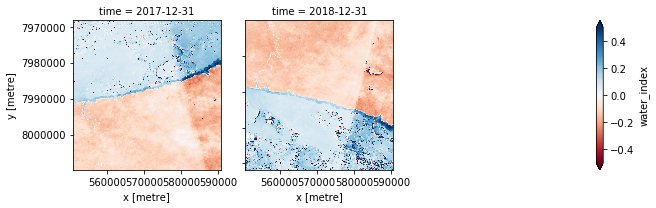

In [62]:
# Combine by time
landsat_resampled = landsat_hightide.water_index.compute().resample(time=time_step).mean('time')
landsat_resampled.plot(col='time', cmap='RdBu', col_wrap=3, vmin=-0.5, vmax=0.5)
#plt.show()

## Extract shorelines from imagery
We now want to extract an accurate shoreline for each each of the summary images above (e.g. 1987, 1989 etc. summaries). The code below identifies the boundary between land and water by tracing a line along pixels with a water index value of `0` (halfway between land and water water index values). It returns a shapefile with one line for each time step:


Operating in single z-value, multiple arrays mode
    Extracting contour 0
    Extracting contour 1
Exporting contour shapefile to output_waterlines.shp


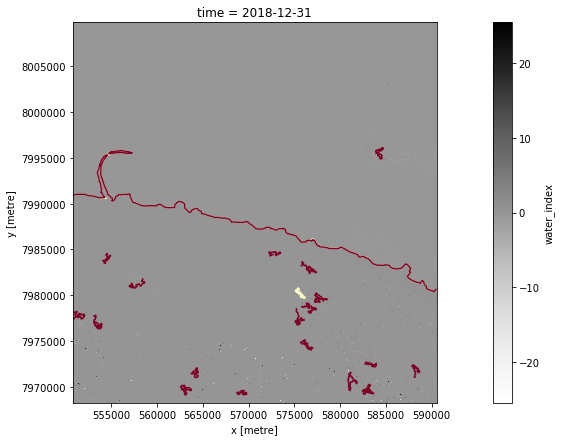

In [63]:
# Set up attributes to assign to each waterline
attribute_data = {'time': [str(i)[0:10] for i in landsat_resampled.time.values]}
attribute_dtypes = {'time': 'str'}

# Extract waterline contours for the '0' water index threshold:
contour_gdf = waterline_funcs.contour_extract(
    z_values=[0],
    ds_array=landsat_resampled,
    ds_crs=landsat_ds.crs,
    ds_affine=landsat_ds.geobox.transform,
    output_shp=f'output_waterlines.shp',
    attribute_data=attribute_data,
    attribute_dtypes=attribute_dtypes,
    min_vertices=50
)

# Plot output shapefile over the top of the first year's MNDWI layer
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
landsat_resampled.isel(time=-1).plot(ax=ax, cmap='Greys', alpha=1.0, edgecolors=None)
contour_gdf.plot(cmap='YlOrRd', ax=ax)


The above plot is a basic visualisation of the contours returned by the `contour_extract` function. Given we now have the shapefile, we can use a more complex function to make an interactive plot for viewing the change in shoreline over time below.

### Plot interactive map of output shorelines coloured by time
The next cell provides an interactive map with an overlay of the shorelines identified in the previous cell. Run it to view the map.

Zoom in to the map below to explore the resulting set of shorelines. Older shorelines are coloured in yellow; more recent shorelines in red (click on the shorelines to return their time period, which will appear below the map). Using this data, we can easily identify areas of rivers or coastline that have changed significantly over time, or areas that have remained stable over the entire time period.

In [64]:
waterline_funcs.map_shapefile(gdf=contour_gdf)

Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/…

## Drawing conclusions
Here are some questions to think about:
* What can you conclude about the change in the shoreline? 
* Which sections of the shoreline have seen the most change? 
* Is the change consistent with erosion? 
* What other information might you need to draw additional conclusions about the cause of the change?

## Next steps
When you are done, return to the "Set up analysis" cell, modify some values and rerun the analysis. Some suggestions for things you can change are:
1. Time range
1. Tide height range
1. Time step
1. Location

If you're going to change the location, you'll need to make sure Landsat 5, 7 and 8 data is available for the new location, which you can check at the [DEAfrica Explorer](https://explorer.digitalearth.africa/) (use the drop-down menu to view all Landsat products). You will  need to find tide heights for your region and store them in the same format as the `data/tide_heights/goldcoast_-28.1483_153.554_tides.csv`. You will also need to update the `tide_file` variable in the set up. You can choose from some existing tide height files in the `data/tide_heights` folder.

## Further exploration
While this notebook mostly utilised the functions available from the Open Data Cube library, some of the steps were conducted with functions from the `waterline_funcs` module, which you can find in the `utils` folder. If you're curious about how these functions work, feel free to explore the `utils/waterline_funcs.py` file. This option is for users who feel comfortable programming in Python. You'll be able to navigate to this file from the Jupyter file explorer page.